In [1]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [4]:
# Load Data

def load_filtered_dfs(data_path, filter_label):
    """
    Loads CSV files from a directory structure and filters them based on labels.
        
    Returns:
    - List of DataFrames that match the filter criteria.
    """
    col_names = [
        'tachometer', 'underhang_axial', 'underhang_radiale', 'underhang_tangential',
        'overhang_axial', 'overhang_radiale', 'overhang_tangential', 'microphone'
    ]

    filtered_dfs = []
    
    for dirname, _, filenames in os.walk(data_path):
        # Ensure filenames are sorted numerically
        filenames = sorted(filenames, key=lambda f: float(f.replace('.csv', '')))
        
        for filename in filenames:
            file_addr = os.path.join(dirname, filename)
            
            if file_addr.endswith('.csv'):
                # Extract label from folder structure
                label = "-".join(file_addr.split('.csv')[0].split("/")[-3:-1])
                
                # Check if any of the filter labels are in the extracted label
                if filter_label in label:
                    print(f"Loading: {file_addr}")
                    df = pd.read_csv(file_addr, names=col_names)
                    filtered_dfs.append(df)
    
    return filtered_dfs

# Downsampling feature engineering
def downSampler(data, b):
    """
    Downsamples the given DataFrame by averaging every 'b' rows.

    Parameters:
    - data (pd.DataFrame): Input time-series data.
    - b (int): Sampling rate (number of rows to aggregate).

    Returns:
    - pd.DataFrame: Downsampled data.
    """
    return data.groupby(data.index // b).mean().reset_index(drop=True)

def rolling_mean_data(df, window_size=100, columns=None):
    """
    Applies a rolling mean transformation to specified columns of a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - window_size (int): Size of the rolling window.
    - columns (list or None): List of columns to apply the rolling mean. If None, applies to all numeric columns.
    
    Returns:
    - pd.DataFrame: Transformed DataFrame with rolling mean applied.
    """
    if columns is None:
        # Select all numeric columns, including 'time' if present
        columns = df.select_dtypes(include=[np.number]).columns  

    df_copy = df.copy()
    df_copy[columns] = df_copy[columns].rolling(window=window_size, min_periods=1).mean()
    
    return df_copy


In [5]:
data_path = "../data"
filter_label = "normal"

normal_dfs = load_filtered_dfs(data_path, filter_label)

normal_df = pd.concat(normal_dfs, ignore_index=True)

normal_df = downSampler(normal_df,2500)
print(normal_df.shape)

normal_df = rolling_mean_data(normal_df)

del normal_dfs

Loading: ../data/normal/normal/12.288.csv
Loading: ../data/normal/normal/13.1072.csv
Loading: ../data/normal/normal/14.336.csv
Loading: ../data/normal/normal/15.1552.csv
Loading: ../data/normal/normal/16.1792.csv
Loading: ../data/normal/normal/17.2032.csv
Loading: ../data/normal/normal/18.432.csv
Loading: ../data/normal/normal/19.6608.csv
Loading: ../data/normal/normal/20.2752.csv
Loading: ../data/normal/normal/21.7088.csv
Loading: ../data/normal/normal/22.3232.csv
Loading: ../data/normal/normal/23.552.csv
Loading: ../data/normal/normal/24.576.csv
Loading: ../data/normal/normal/25.6.csv
Loading: ../data/normal/normal/26.624.csv
Loading: ../data/normal/normal/27.4432.csv
Loading: ../data/normal/normal/28.8768.csv
Loading: ../data/normal/normal/29.4912.csv
Loading: ../data/normal/normal/30.72.csv
Loading: ../data/normal/normal/31.744.csv
Loading: ../data/normal/normal/32.9728.csv
Loading: ../data/normal/normal/33.5872.csv
Loading: ../data/normal/normal/34.2016.csv
Loading: ../data/normal

In [6]:
filter_label = "imbalance-6g"

imbalance_dfs = load_filtered_dfs(data_path, filter_label)

imbalance_df = pd.concat(imbalance_dfs, ignore_index=True)

imbalance_df = downSampler(imbalance_df,2500)
print(imbalance_df.shape)

imbalance_df = rolling_mean_data(imbalance_df)

del imbalance_dfs

imbalance_df = rolling_mean_data(imbalance_df)


Loading: ../data/imbalance/imbalance/6g/13.9264.csv
Loading: ../data/imbalance/imbalance/6g/14.336.csv
Loading: ../data/imbalance/imbalance/6g/15.36.csv
Loading: ../data/imbalance/imbalance/6g/16.1792.csv
Loading: ../data/imbalance/imbalance/6g/17.408.csv
Loading: ../data/imbalance/imbalance/6g/18.432.csv
Loading: ../data/imbalance/imbalance/6g/19.6608.csv
Loading: ../data/imbalance/imbalance/6g/20.2752.csv
Loading: ../data/imbalance/imbalance/6g/21.7088.csv
Loading: ../data/imbalance/imbalance/6g/22.7328.csv
Loading: ../data/imbalance/imbalance/6g/23.552.csv
Loading: ../data/imbalance/imbalance/6g/24.576.csv
Loading: ../data/imbalance/imbalance/6g/25.3952.csv
Loading: ../data/imbalance/imbalance/6g/26.8288.csv
Loading: ../data/imbalance/imbalance/6g/27.648.csv
Loading: ../data/imbalance/imbalance/6g/28.8768.csv
Loading: ../data/imbalance/imbalance/6g/29.4912.csv
Loading: ../data/imbalance/imbalance/6g/30.5152.csv
Loading: ../data/imbalance/imbalance/6g/31.5392.csv
Loading: ../data/imb

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def concatenate_with_labels(df1, label1, df2, label2):
    """
    Concatenates two DataFrames and adds a 'label' column to each for visualization.
    
    Parameters:
    - df1 (pd.DataFrame): First DataFrame
    - label1 (str): Label for the first DataFrame
    - df2 (pd.DataFrame): Second DataFrame
    - label2 (str): Label for the second DataFrame
    
    Returns:
    - pd.DataFrame: Concatenated DataFrame with labels
    """
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    # Add label columns
    df1_copy['label'] = label1
    df2_copy['label'] = label2

    # Concatenate DataFrames
    combined_df = pd.concat([df1_copy, df2_copy], ignore_index=True)
    
    return combined_df

all_data = concatenate_with_labels(normal_df, "normal", imbalance_df, "imbalance")

In [11]:
all_data['label'] = all_data['label'].map({
    'normal': 0,
    'imbalance': 1
})

all_data.head()

,tachometer,underhang_axial,underhang_radiale,underhang_tangential,overhang_axial,overhang_radiale,overhang_tangential,microphone,label
0,0.141525,-0.097450,-0.011537,-0.002896,0.059372,0.004494,-0.049841,0.016333,0
1,0.242437,-0.014098,0.000813,-0.000227,0.213509,0.005441,0.004664,0.008777,0
2,-0.022340,-0.013451,-0.000239,-0.000121,0.141989,0.002529,0.016295,0.008953,0
3,0.068712,-0.029785,-0.003180,-0.000661,0.011702,0.002159,0.003672,0.010858,0
4,0.041643,-0.011061,-0.001103,0.000126,-0.086091,0.001652,-0.031693,0.007617,0


In [12]:
all_data.tail()

,tachometer,underhang_axial,underhang_radiale,underhang_tangential,overhang_axial,overhang_radiale,overhang_tangential,microphone,label
9795,0.001398,-0.000718,-0.000854,0.000368,0.006163,0.002628,0.135778,0.012967,1
9796,0.001402,-0.000698,-0.000855,0.000367,0.006128,0.002624,0.132933,0.012969,1
9797,0.001404,-0.000682,-0.000855,0.000366,0.006087,0.002617,0.130155,0.012971,1
9798,0.001400,-0.000669,-0.000857,0.000366,0.006060,0.002613,0.127535,0.012974,1
9799,0.001396,-0.000660,-0.000855,0.000365,0.006050,0.002614,0.125146,0.012976,1


In [15]:
class MachineryDataset(Dataset):
    def __init__(self, data, label_column='label'):
        """
        data: A pandas DataFrame containing the final features.
        label_column: The name of the column that contains the target label.
                      For multi-class, this might be an integer. For binary, 0/1.
        """
        self.labels = data[label_column].values
        # Drop non-feature columns
        self.features = data.drop(columns=[label_column, 'time'], errors='ignore').values.astype('float32')
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

class TimeSeriesMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=2):
        super(TimeSeriesMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

def train_model(model, train_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.long().to(device)  
            
            optimizer.zero_grad()
            outputs = model(X)
            
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


In [16]:
# Create dataset & dataloader
train_dataset = MachineryDataset(all_data, label_column='label')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 4. Initialize model, loss, optimizer
input_dim = train_dataset.features.shape[1]  # number of columns after feature engineering
model = TimeSeriesMLP(input_dim=input_dim, hidden_dim=3, num_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. Train
train_model(model, train_loader, criterion, optimizer, epochs=10, device='cpu')


Epoch [1/10], Loss: 0.7311
Epoch [2/10], Loss: 0.6951
Epoch [3/10], Loss: 0.6923
Epoch [4/10], Loss: 0.6915
Epoch [5/10], Loss: 0.6905
Epoch [6/10], Loss: 0.6894
Epoch [7/10], Loss: 0.6878
Epoch [8/10], Loss: 0.6857
Epoch [9/10], Loss: 0.6826
Epoch [10/10], Loss: 0.6781


Epoch [1/100], Loss: 0.6048, Accuracy: 68.92%
Epoch [2/100], Loss: 0.6016, Accuracy: 69.37%
Epoch [3/100], Loss: 0.5984, Accuracy: 69.47%
Epoch [4/100], Loss: 0.5950, Accuracy: 69.70%
Epoch [5/100], Loss: 0.5915, Accuracy: 70.23%
Epoch [6/100], Loss: 0.5879, Accuracy: 70.59%
Epoch [7/100], Loss: 0.5844, Accuracy: 71.23%
Epoch [8/100], Loss: 0.5803, Accuracy: 71.69%
Epoch [9/100], Loss: 0.5766, Accuracy: 72.23%
Epoch [10/100], Loss: 0.5724, Accuracy: 72.73%
Epoch [11/100], Loss: 0.5680, Accuracy: 73.49%
Epoch [12/100], Loss: 0.5633, Accuracy: 73.79%
Epoch [13/100], Loss: 0.5586, Accuracy: 74.63%
Epoch [14/100], Loss: 0.5538, Accuracy: 75.27%
Epoch [15/100], Loss: 0.5485, Accuracy: 76.01%
Epoch [16/100], Loss: 0.5436, Accuracy: 76.43%
Epoch [17/100], Loss: 0.5383, Accuracy: 77.22%
Epoch [18/100], Loss: 0.5328, Accuracy: 77.79%
Epoch [19/100], Loss: 0.5273, Accuracy: 78.16%
Epoch [20/100], Loss: 0.5222, Accuracy: 78.60%
Epoch [21/100], Loss: 0.5168, Accuracy: 78.69%
Epoch [22/100], Loss: 

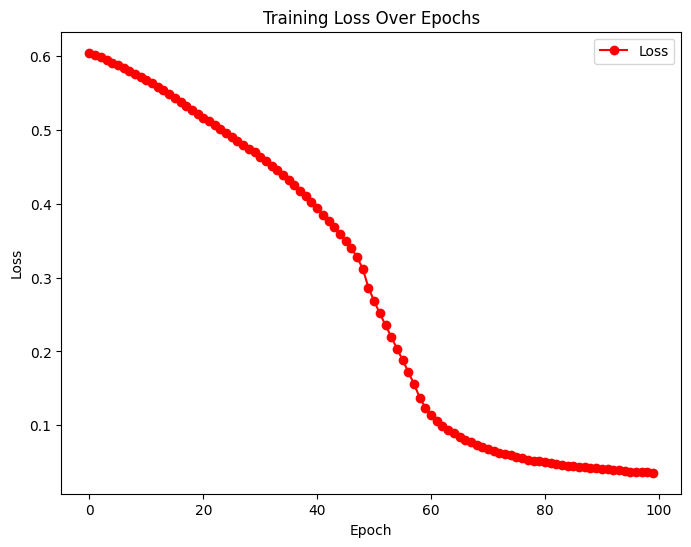

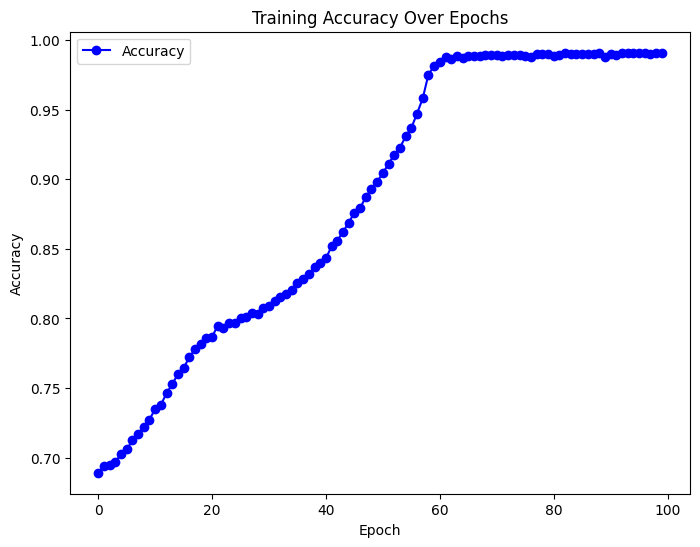

In [18]:
def train_model(model, train_loader, criterion, optimizer, epochs=100, device='cpu'):
    model.to(device)
    
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for X, y in train_loader:
            X, y = X.to(device), y.long().to(device)
            
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}]"
              f", Loss: {epoch_loss:.4f}"
              f", Accuracy: {epoch_acc*100:.2f}%")
        
    return train_losses, train_accuracies

# Usage:
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer)

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, 'r-o', label="Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, 'b-o', label="Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
